In [31]:
from datasets import Dataset, DatasetDict, IterableDataset, IterableDatasetDict
from datasets import load_dataset

raw_datasets = load_dataset('tomaarsen/MultiCoNER', 'multi')

c:\Users\Pejoy\anaconda3\envs\nlp_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
raw_datasets
num_labels = len(raw_datasets['train'].features['ner_tags'].feature.names)
raw_datasets['train'].features['ner_tags'].feature.names

['O',
 'B-PER',
 'I-PER',
 'B-LOC',
 'I-LOC',
 'B-CORP',
 'I-CORP',
 'B-GRP',
 'I-GRP',
 'B-PROD',
 'I-PROD',
 'B-CW',
 'I-CW']

In [10]:
raw_datasets = raw_datasets.shuffle(seed=42)
raw_datasets = DatasetDict({
    split: dataset.select(range(int(0.2 * len(dataset)))) if split != 'test' else dataset
    for split, dataset in raw_datasets.items()
})
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 33660
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1760
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 471911
    })
})

In [7]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def visualize_training_log(log_file_path):
    """
    Parse the training log and visualize training metrics.
    
    Args:
        log_file_path (str): Path to the training log file
    """
    # 读取日志文件
    with open(log_file_path, 'r') as f:
        log_content = f.read()
    
    # 提取训练和评估指标
    train_pattern = r"{'loss': ([\d.]+), 'grad_norm': ([\d.nan]+), 'learning_rate': ([\d.e-]+), 'epoch': ([\d.]+)}"
    eval_pattern = r"{'eval_loss': ([\d.]+), 'eval_precision': ([\d.]+), 'eval_recall': ([\d.]+), 'eval_f1': ([\d.]+)"
    
    train_matches = re.findall(train_pattern, log_content)
    eval_matches = re.findall(eval_pattern, log_content)
    
    # 转换为 DataFrame
    train_df = pd.DataFrame(train_matches, columns=['loss', 'grad_norm', 'learning_rate', 'epoch'], dtype=float)
    eval_df = pd.DataFrame(eval_matches, columns=['eval_loss', 'eval_precision', 'eval_recall', 'eval_f1'], dtype=float)
    
    # 添加 epoch 列到评估 DataFrame
    eval_pattern_epoch = r"'eval_f1': [\d.]+, 'eval_runtime': [\d.]+, 'eval_samples_per_second': [\d.]+, 'eval_steps_per_second': [\d.]+, 'epoch': ([\d.]+)}"
    eval_epochs = re.findall(eval_pattern_epoch, log_content)
    eval_df['epoch'] = [float(epoch) for epoch in eval_epochs]
    
    # 设置风格
    sns.set_theme(style='whitegrid')
    plt.figure(figsize=(20, 16))
    
    # 1. 训练和评估损失
    plt.subplot(2, 2, 1)
    plt.plot(train_df['epoch'], train_df['loss'], 'b-', label='Training Loss')
    plt.plot(eval_df['epoch'], eval_df['eval_loss'], 'r-', label='Validation Loss')
    plt.title('Loss vs Epoch', fontsize=15)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # 2. F1、Precision 和 Recall
    plt.subplot(2, 2, 2)
    plt.plot(eval_df['epoch'], eval_df['eval_f1'], 'g-', label='F1 Score')
    plt.plot(eval_df['epoch'], eval_df['eval_precision'], 'b-', label='Precision')
    plt.plot(eval_df['epoch'], eval_df['eval_recall'], 'r-', label='Recall')
    plt.title('F1, Precision, Recall vs Epoch', fontsize=15)
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    
    # 3. F1 分数的增长率
    plt.subplot(2, 2, 3)
    f1_change = eval_df['eval_f1'].diff() / eval_df['eval_f1'].shift(1) * 100
    plt.bar(eval_df['epoch'][1:].values, f1_change[1:].values, color='green', alpha=0.7)
    plt.title('F1 Score Percentage Change per Evaluation', fontsize=15)
    plt.xlabel('Epoch')
    plt.ylabel('F1 Change (%)')
    plt.grid(True)
    
    # 4. 学习率变化
    plt.subplot(2, 2, 4)
    plt.plot(train_df['epoch'], train_df['learning_rate'], 'c-')
    plt.title('Learning Rate vs Epoch', fontsize=15)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    
    # 添加总标题
    plt.suptitle('Training and Evaluation Metrics', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # 保存图表
    plt.savefig('training_metrics.png', dpi=300)
    plt.show()
    
    # 返回最高 F1 分数和对应的 epoch
    max_f1_idx = eval_df['eval_f1'].idxmax()
    max_f1 = eval_df.iloc[max_f1_idx]
    print(f"\nBest F1 Score: {max_f1['eval_f1']:.4f} at epoch {max_f1['epoch']}")
    print(f"Corresponding Precision: {max_f1['eval_precision']:.4f}, Recall: {max_f1['eval_recall']:.4f}")
    
    # 计算每个评估步骤 F1 的增长
    eval_df['f1_diff'] = eval_df['eval_f1'].diff()
    print("\nF1 Score Improvements:")
    for i, row in eval_df[1:].iterrows():
        print(f"Epoch {row['epoch']:.2f}: F1 change: {row['f1_diff']:.4f} ({row['f1_diff']/eval_df.iloc[i-1]['eval_f1']*100:.2f}%)")

    return train_df, eval_df


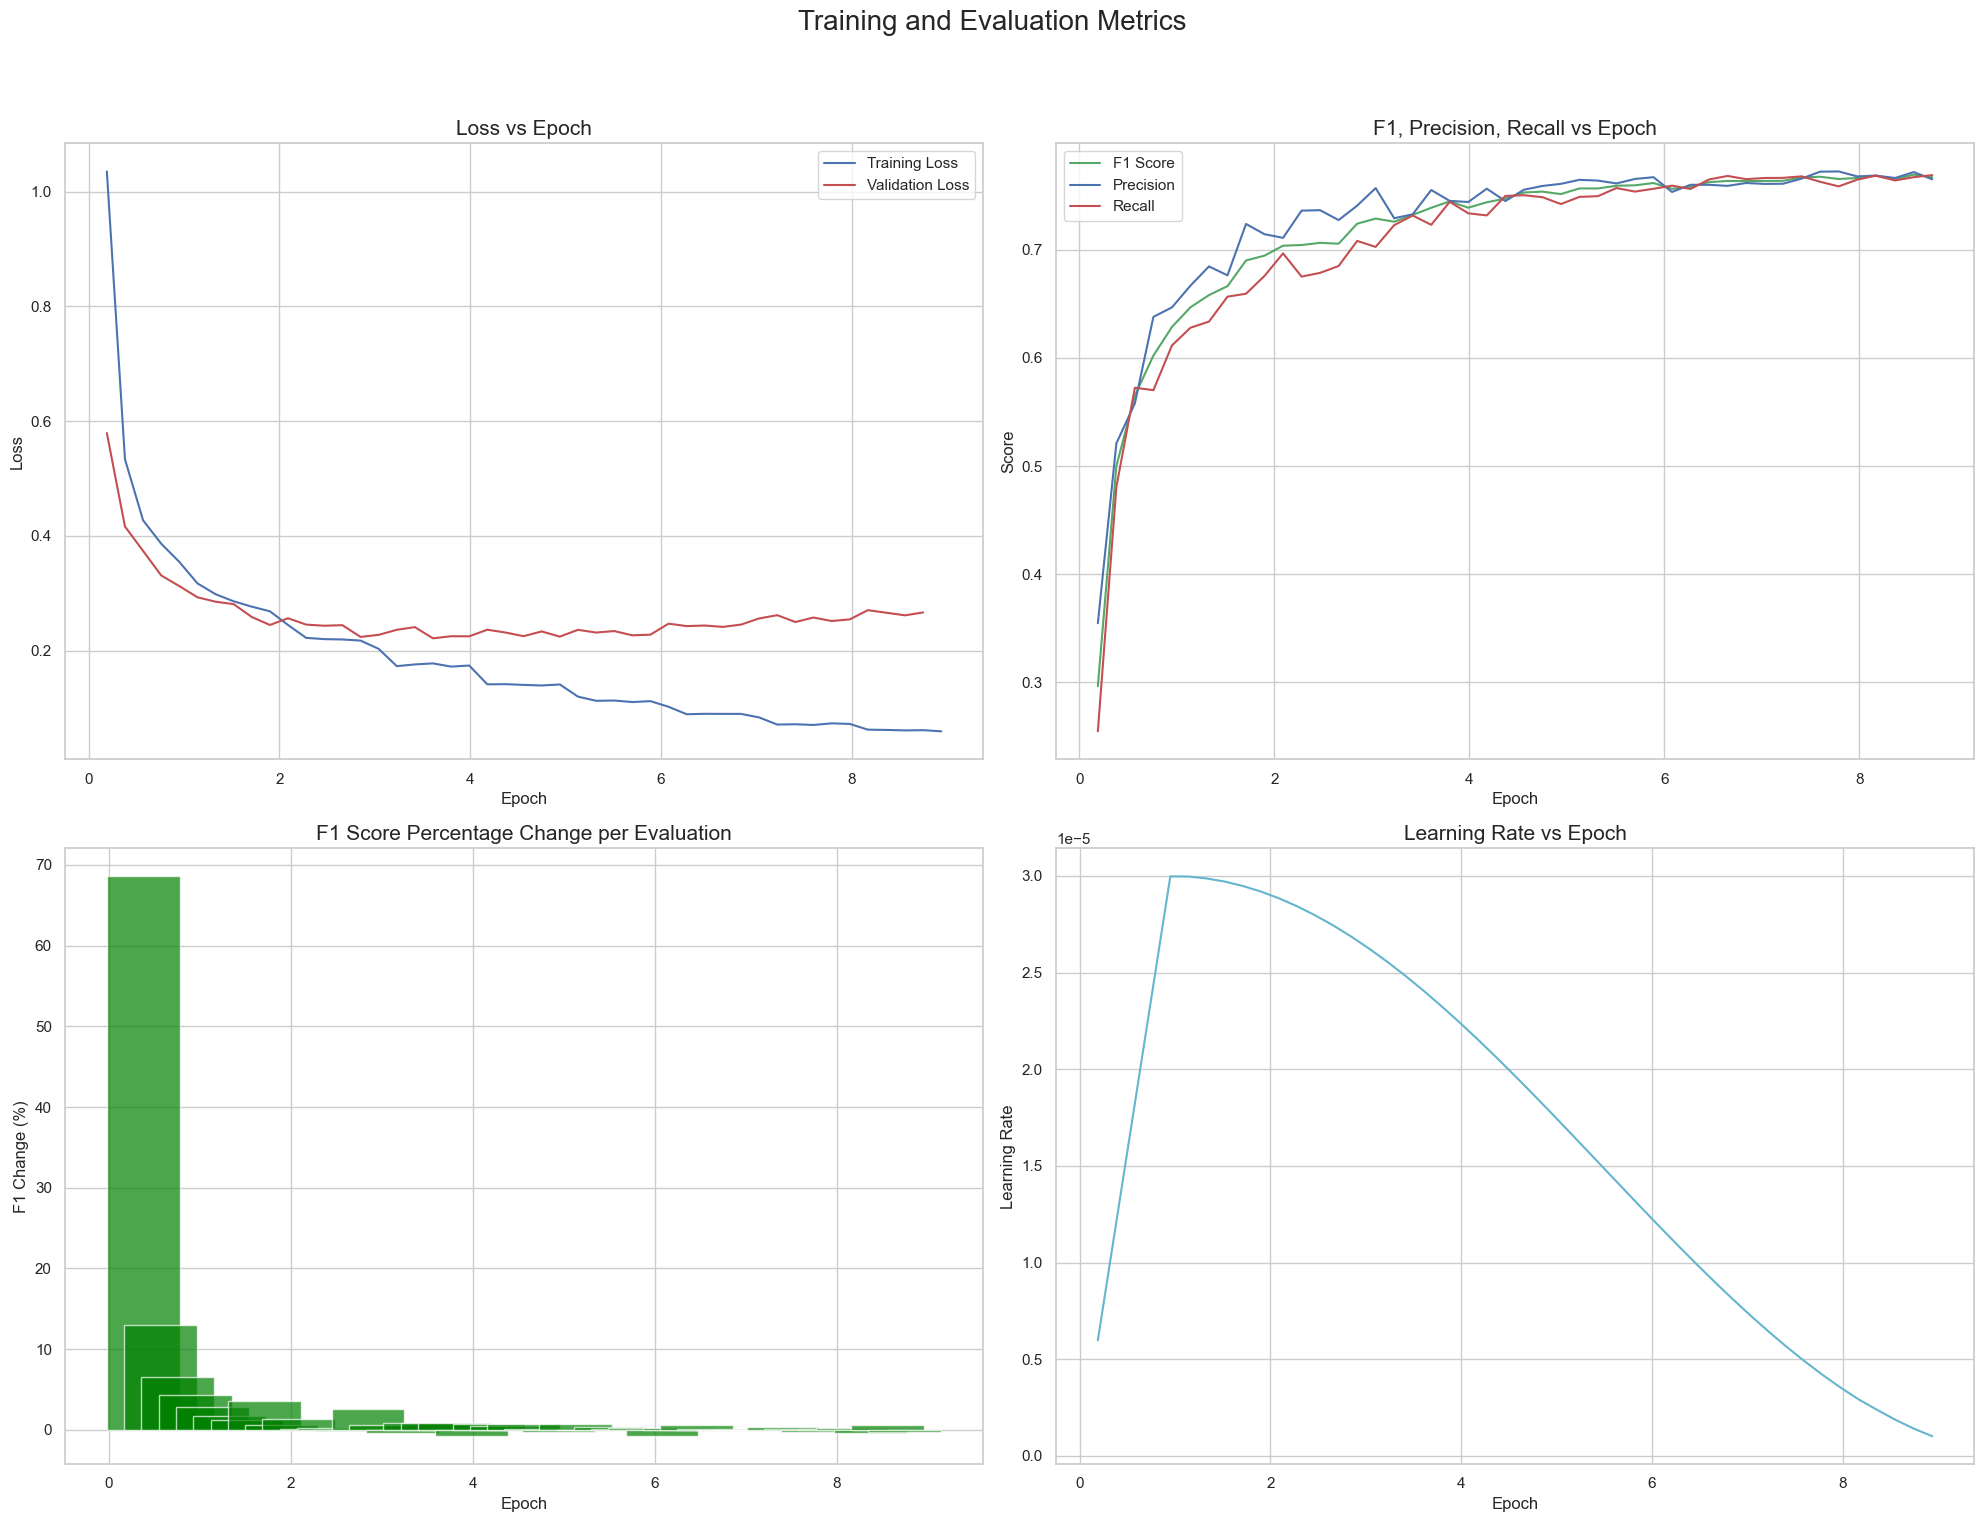


Best F1 Score: 0.7694 at epoch 8.56
Corresponding Precision: 0.7718, Recall: 0.7670

F1 Score Improvements:
Epoch 0.38: F1 change: 0.2034 (68.58%)
Epoch 0.57: F1 change: 0.0651 (13.01%)
Epoch 0.76: F1 change: 0.0371 (6.56%)
Epoch 0.95: F1 change: 0.0264 (4.39%)
Epoch 1.14: F1 change: 0.0182 (2.89%)
Epoch 1.33: F1 change: 0.0113 (1.75%)
Epoch 1.52: F1 change: 0.0083 (1.26%)
Epoch 1.71: F1 change: 0.0237 (3.56%)
Epoch 1.90: F1 change: 0.0045 (0.65%)
Epoch 2.09: F1 change: 0.0092 (1.32%)
Epoch 2.28: F1 change: 0.0006 (0.09%)
Epoch 2.47: F1 change: 0.0020 (0.29%)
Epoch 2.66: F1 change: -0.0008 (-0.12%)
Epoch 2.85: F1 change: 0.0185 (2.62%)
Epoch 3.04: F1 change: 0.0047 (0.65%)
Epoch 3.23: F1 change: -0.0029 (-0.39%)
Epoch 3.42: F1 change: 0.0063 (0.86%)
Epoch 3.61: F1 change: 0.0066 (0.90%)
Epoch 3.80: F1 change: 0.0059 (0.80%)
Epoch 3.99: F1 change: -0.0059 (-0.79%)
Epoch 4.18: F1 change: 0.0050 (0.68%)
Epoch 4.37: F1 change: 0.0035 (0.47%)
Epoch 4.56: F1 change: 0.0055 (0.74%)
Epoch 4.7

In [10]:
train_df, eval_df = visualize_training_log('train.log')

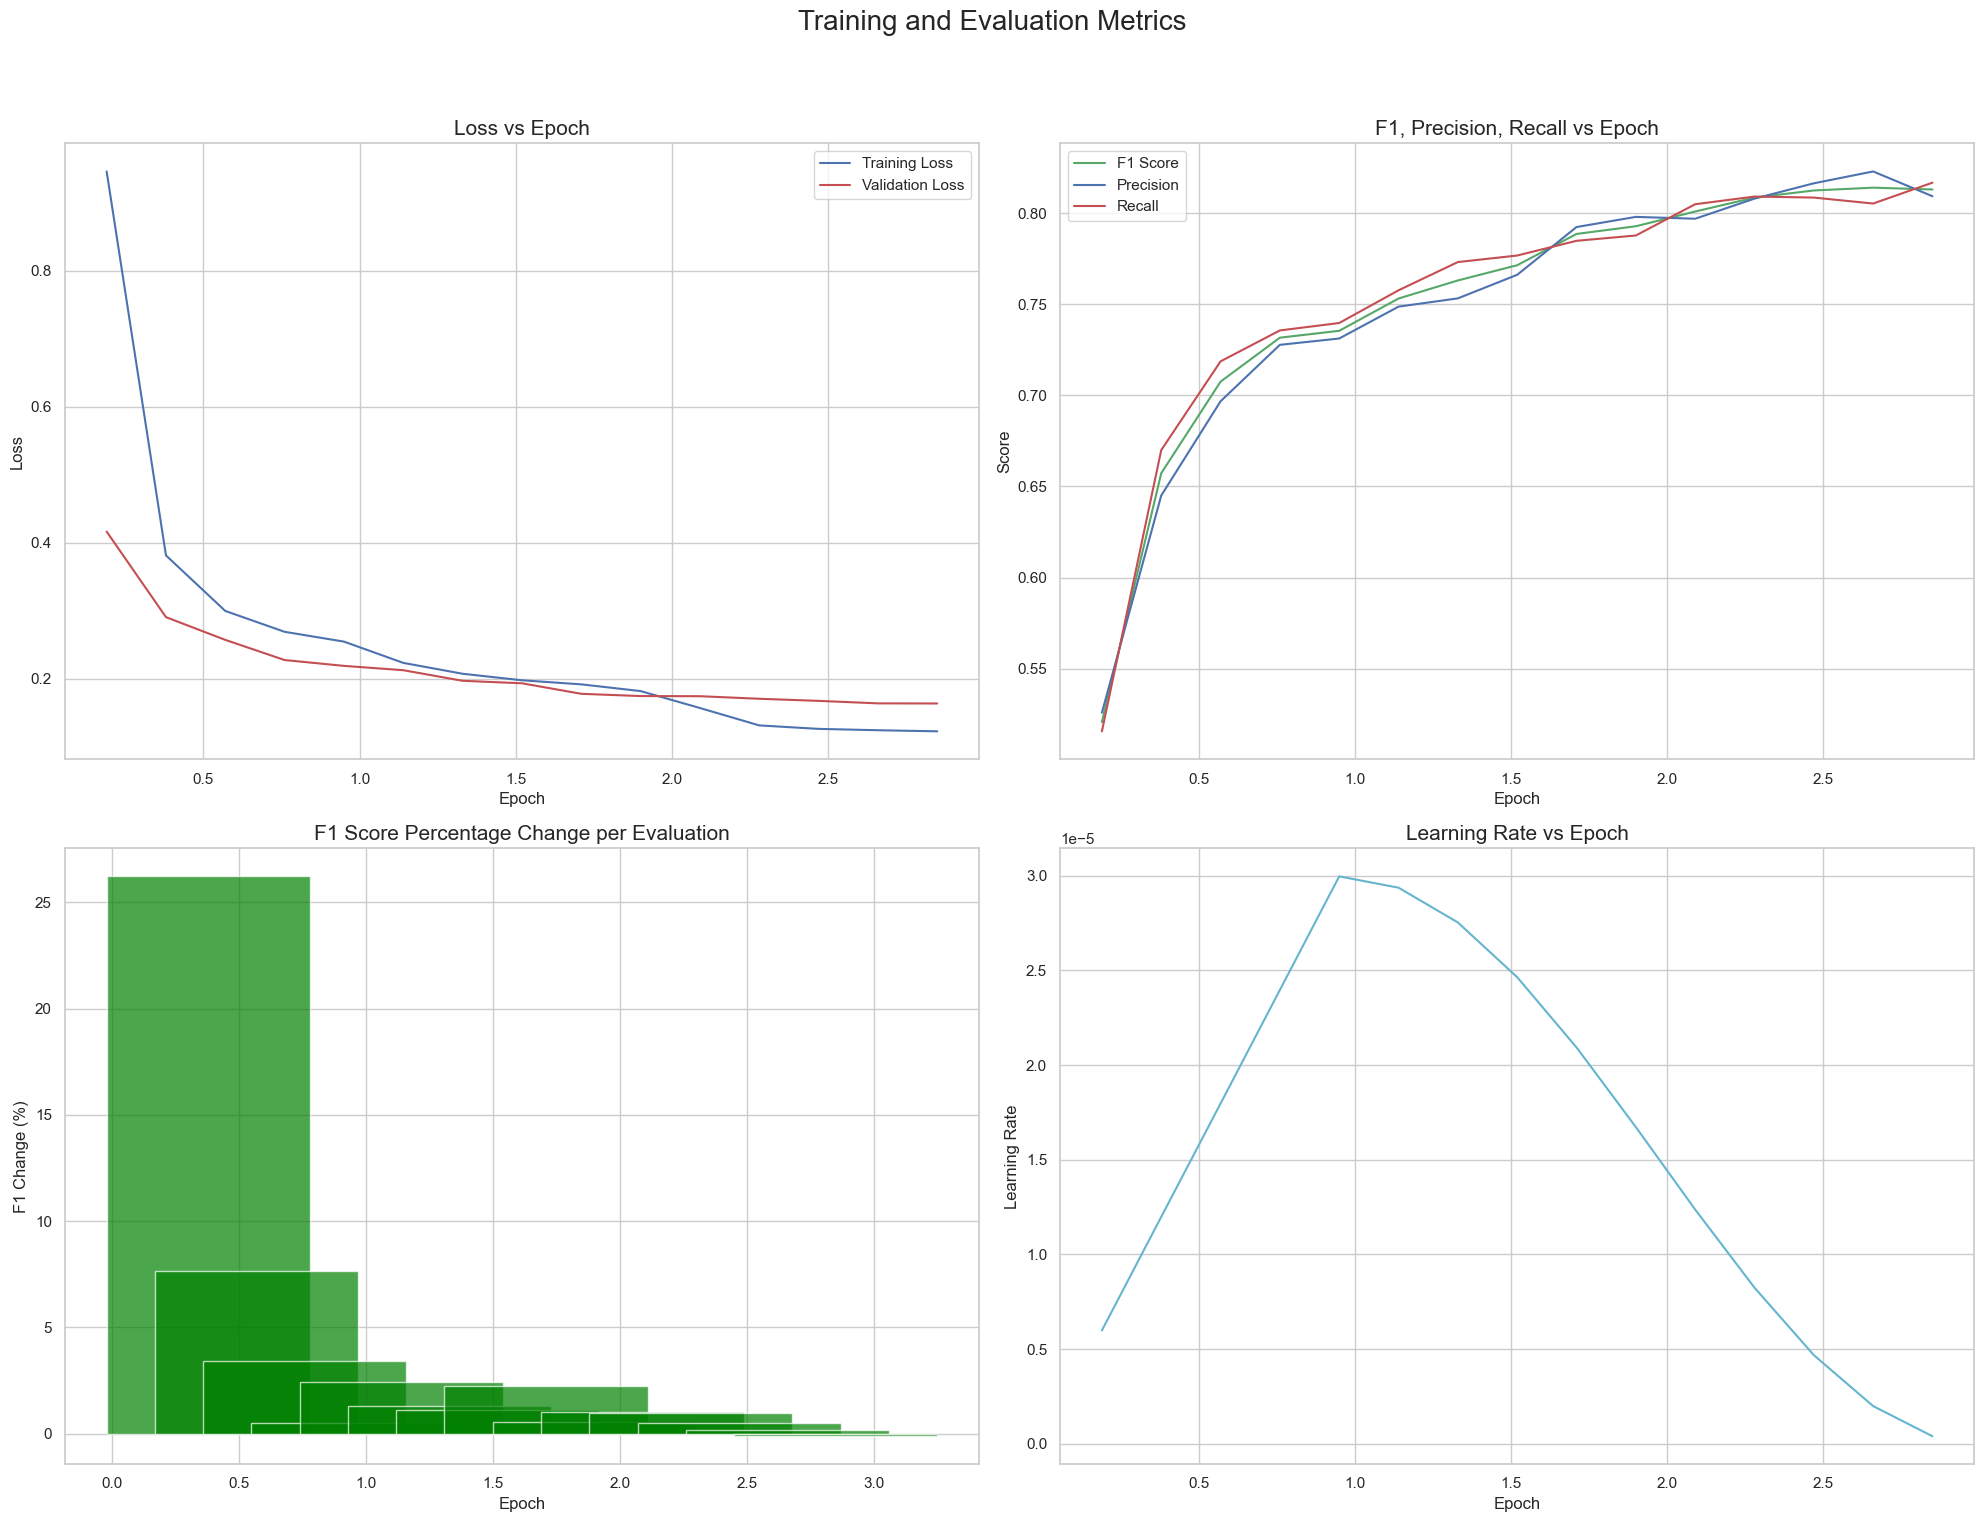


Best F1 Score: 0.8139 at epoch 2.66
Corresponding Precision: 0.8228, Recall: 0.8052

F1 Score Improvements:
Epoch 0.38: F1 change: 0.1365 (26.22%)
Epoch 0.57: F1 change: 0.0503 (7.65%)
Epoch 0.76: F1 change: 0.0241 (3.41%)
Epoch 0.95: F1 change: 0.0038 (0.52%)
Epoch 1.14: F1 change: 0.0177 (2.41%)
Epoch 1.33: F1 change: 0.0099 (1.32%)
Epoch 1.52: F1 change: 0.0084 (1.09%)
Epoch 1.71: F1 change: 0.0172 (2.22%)
Epoch 1.90: F1 change: 0.0042 (0.54%)
Epoch 2.09: F1 change: 0.0081 (1.02%)
Epoch 2.28: F1 change: 0.0076 (0.95%)
Epoch 2.47: F1 change: 0.0039 (0.48%)
Epoch 2.66: F1 change: 0.0015 (0.19%)
Epoch 2.85: F1 change: -0.0010 (-0.12%)


In [21]:
train_df, eval_df = visualize_training_log('train_xlm_base_3e-5.log')

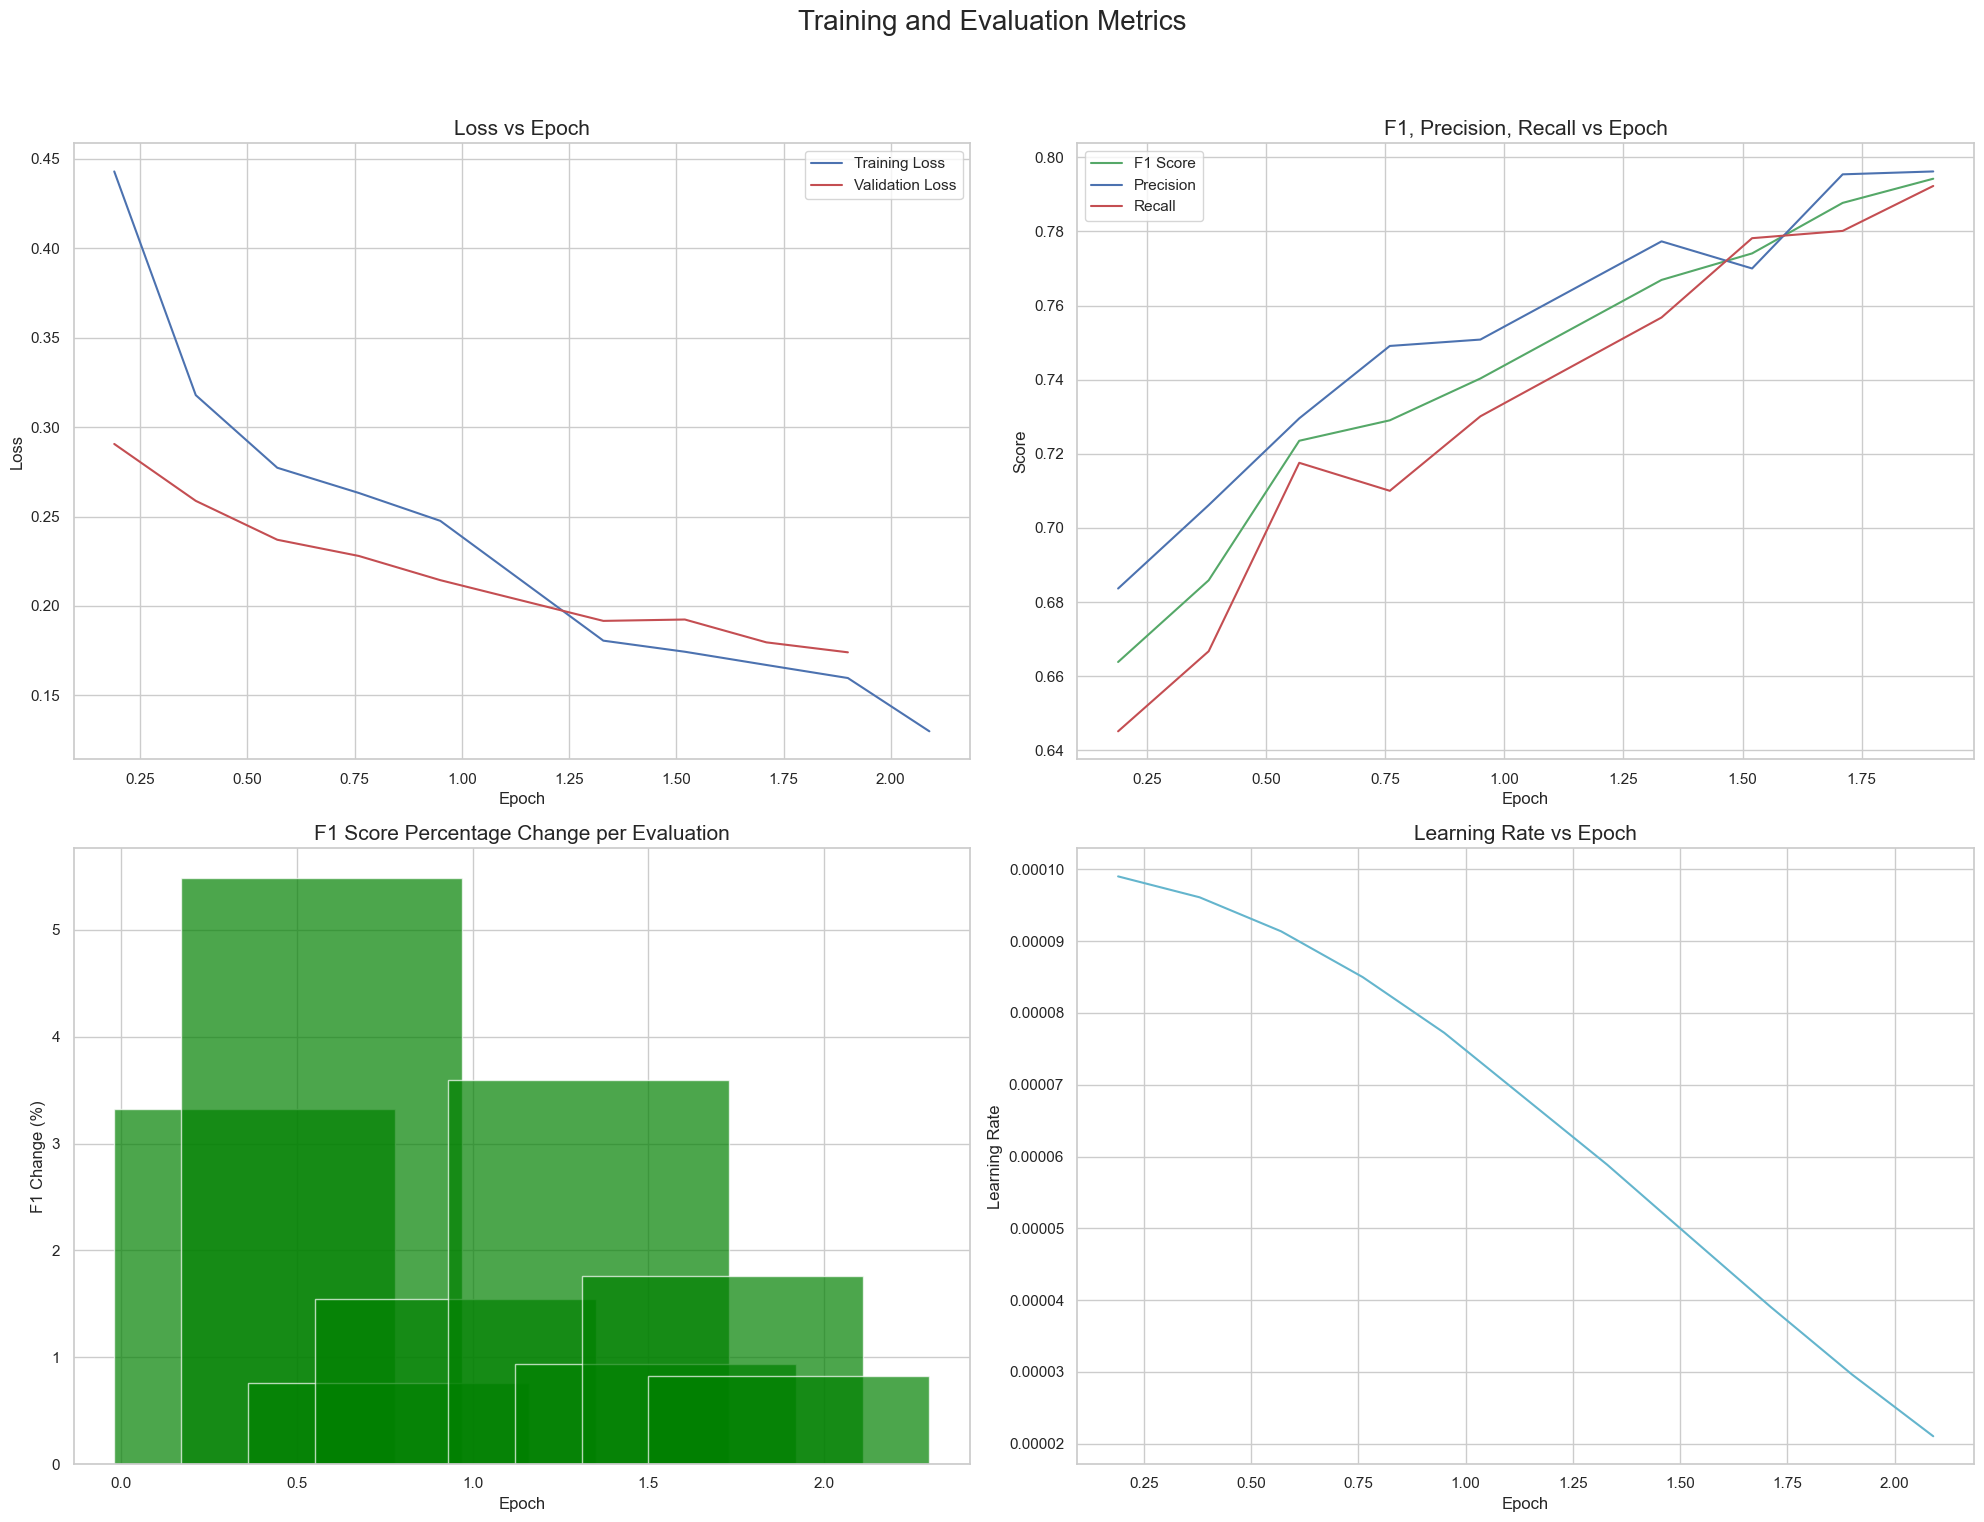


Best F1 Score: 0.7942 at epoch 1.9
Corresponding Precision: 0.7962, Recall: 0.7923

F1 Score Improvements:
Epoch 0.38: F1 change: 0.0220 (3.32%)
Epoch 0.57: F1 change: 0.0376 (5.49%)
Epoch 0.76: F1 change: 0.0055 (0.76%)
Epoch 0.95: F1 change: 0.0113 (1.55%)
Epoch 1.33: F1 change: 0.0266 (3.59%)
Epoch 1.52: F1 change: 0.0072 (0.93%)
Epoch 1.71: F1 change: 0.0136 (1.76%)
Epoch 1.90: F1 change: 0.0065 (0.83%)


In [24]:
train_df, eval_df = visualize_training_log('train_xlm_base_1e-4.log')

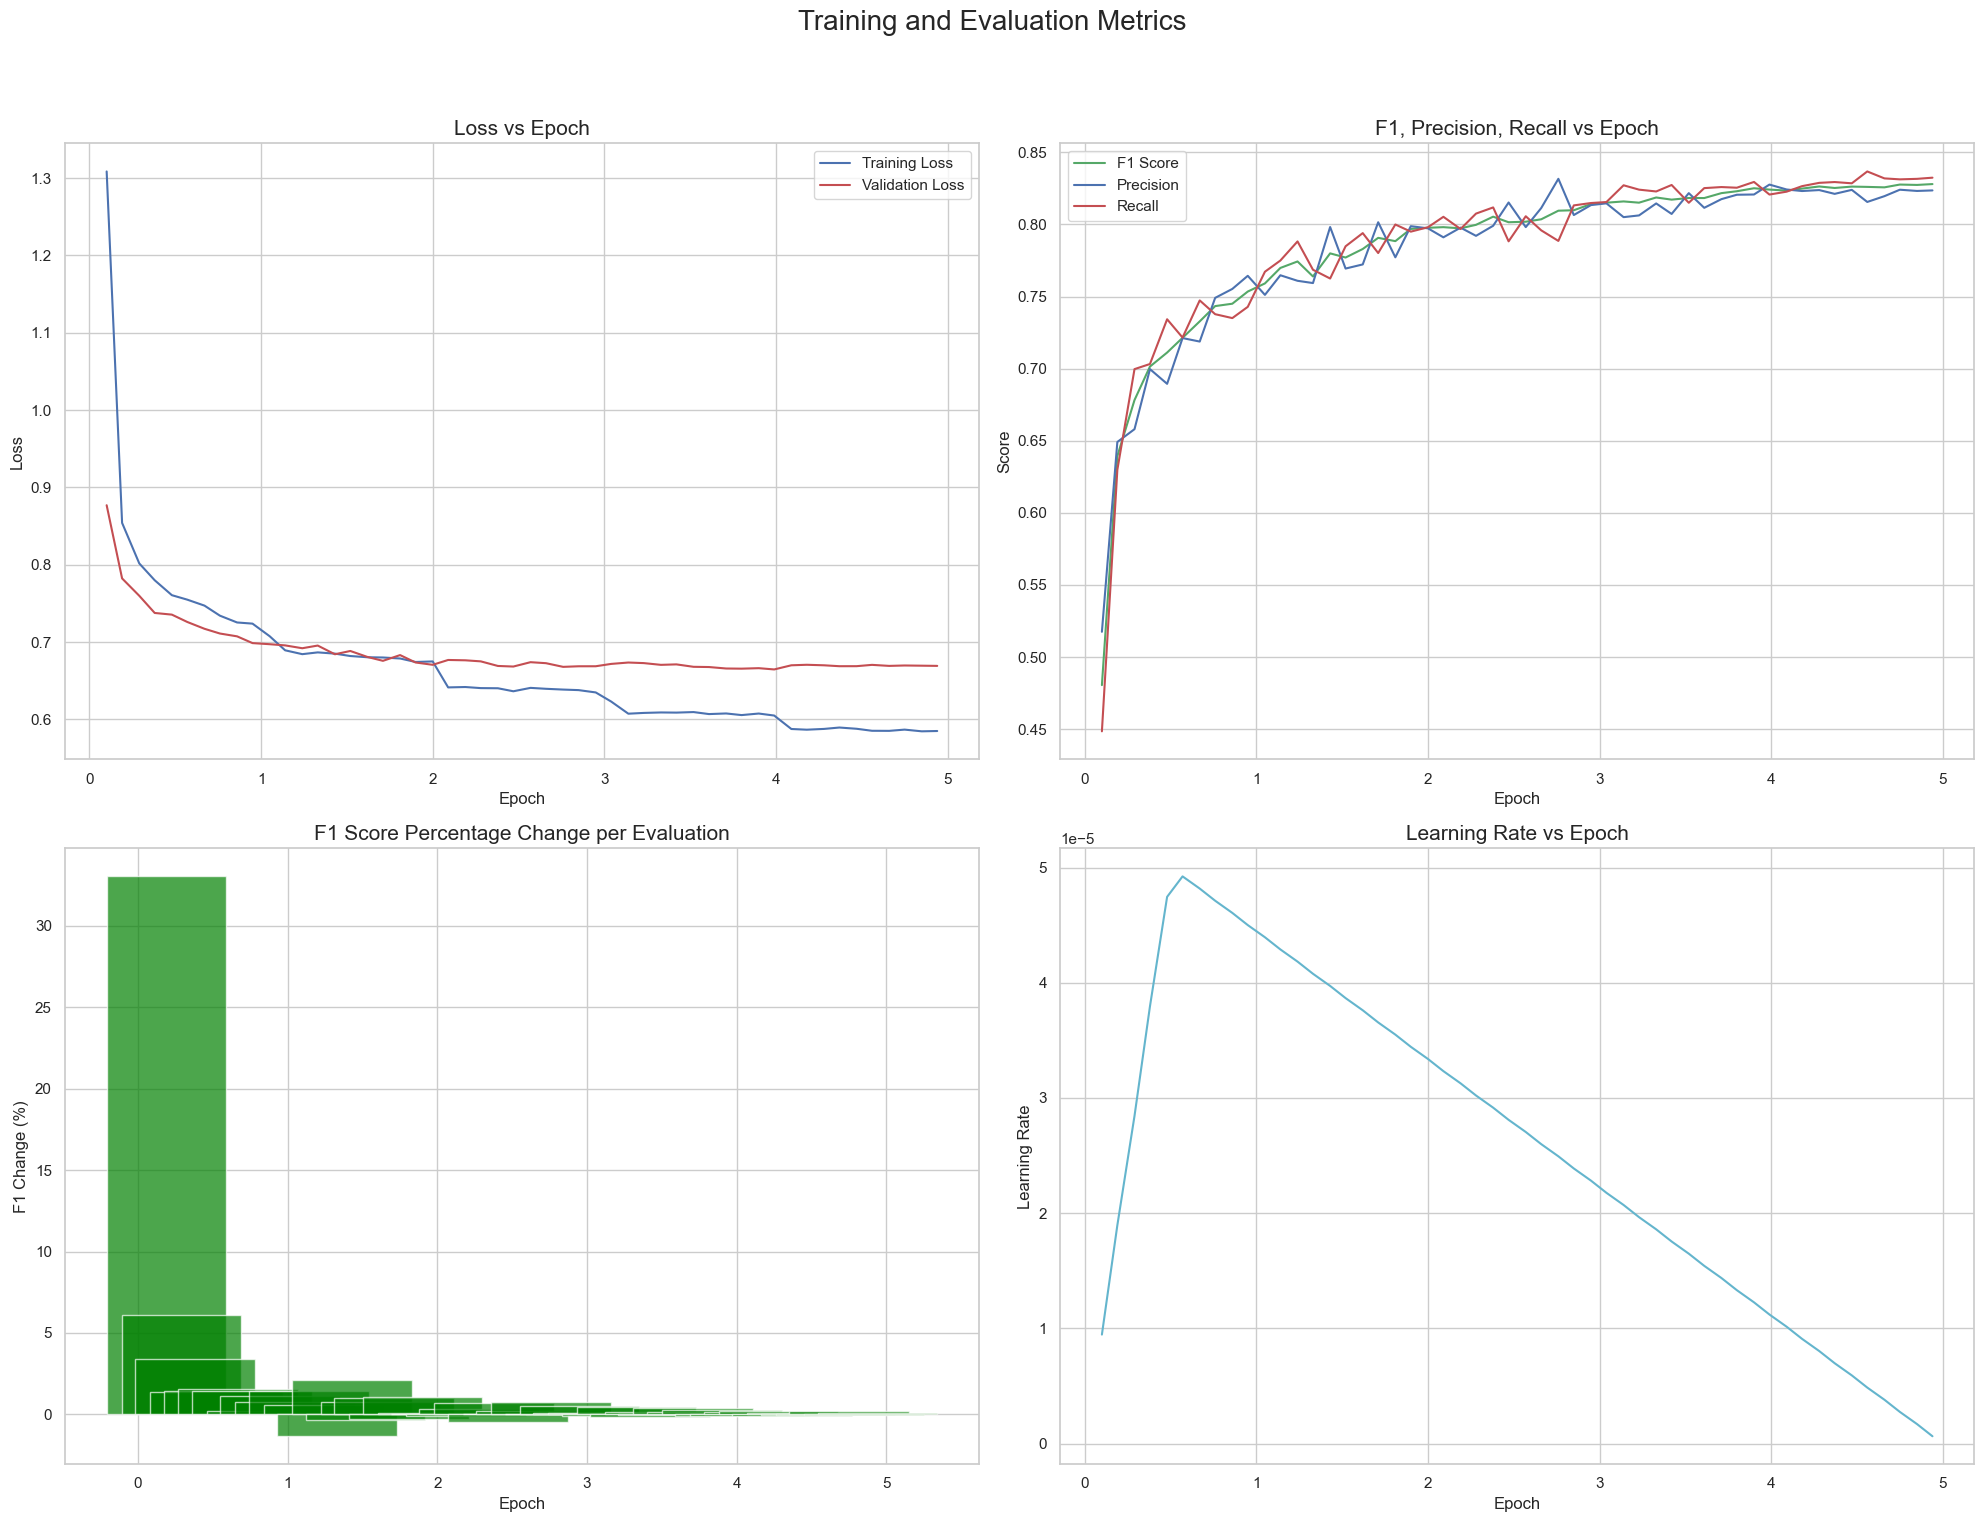


Best F1 Score: 0.8279 at epoch 4.94
Corresponding Precision: 0.8236, Recall: 0.8324

F1 Score Improvements:
Epoch 0.19: F1 change: 0.1588 (33.04%)
Epoch 0.29: F1 change: 0.0389 (6.08%)
Epoch 0.38: F1 change: 0.0232 (3.43%)
Epoch 0.48: F1 change: 0.0097 (1.38%)
Epoch 0.57: F1 change: 0.0102 (1.44%)
Epoch 0.67: F1 change: 0.0114 (1.58%)
Epoch 0.76: F1 change: 0.0106 (1.45%)
Epoch 0.86: F1 change: 0.0017 (0.22%)
Epoch 0.95: F1 change: 0.0084 (1.13%)
Epoch 1.05: F1 change: 0.0056 (0.75%)
Epoch 1.14: F1 change: 0.0107 (1.41%)
Epoch 1.24: F1 change: 0.0045 (0.58%)
Epoch 1.33: F1 change: -0.0104 (-1.34%)
Epoch 1.43: F1 change: 0.0160 (2.10%)
Epoch 1.52: F1 change: -0.0029 (-0.37%)
Epoch 1.62: F1 change: 0.0059 (0.76%)
Epoch 1.71: F1 change: 0.0077 (0.99%)
Epoch 1.81: F1 change: -0.0023 (-0.29%)
Epoch 1.90: F1 change: 0.0085 (1.07%)
Epoch 2.00: F1 change: 0.0008 (0.10%)
Epoch 2.09: F1 change: 0.0004 (0.05%)
Epoch 2.19: F1 change: -0.0008 (-0.10%)
Epoch 2.28: F1 change: 0.0024 (0.30%)
Epoch 2.

In [27]:
train_df, eval_df = visualize_training_log('train_xlm_base_param.log')

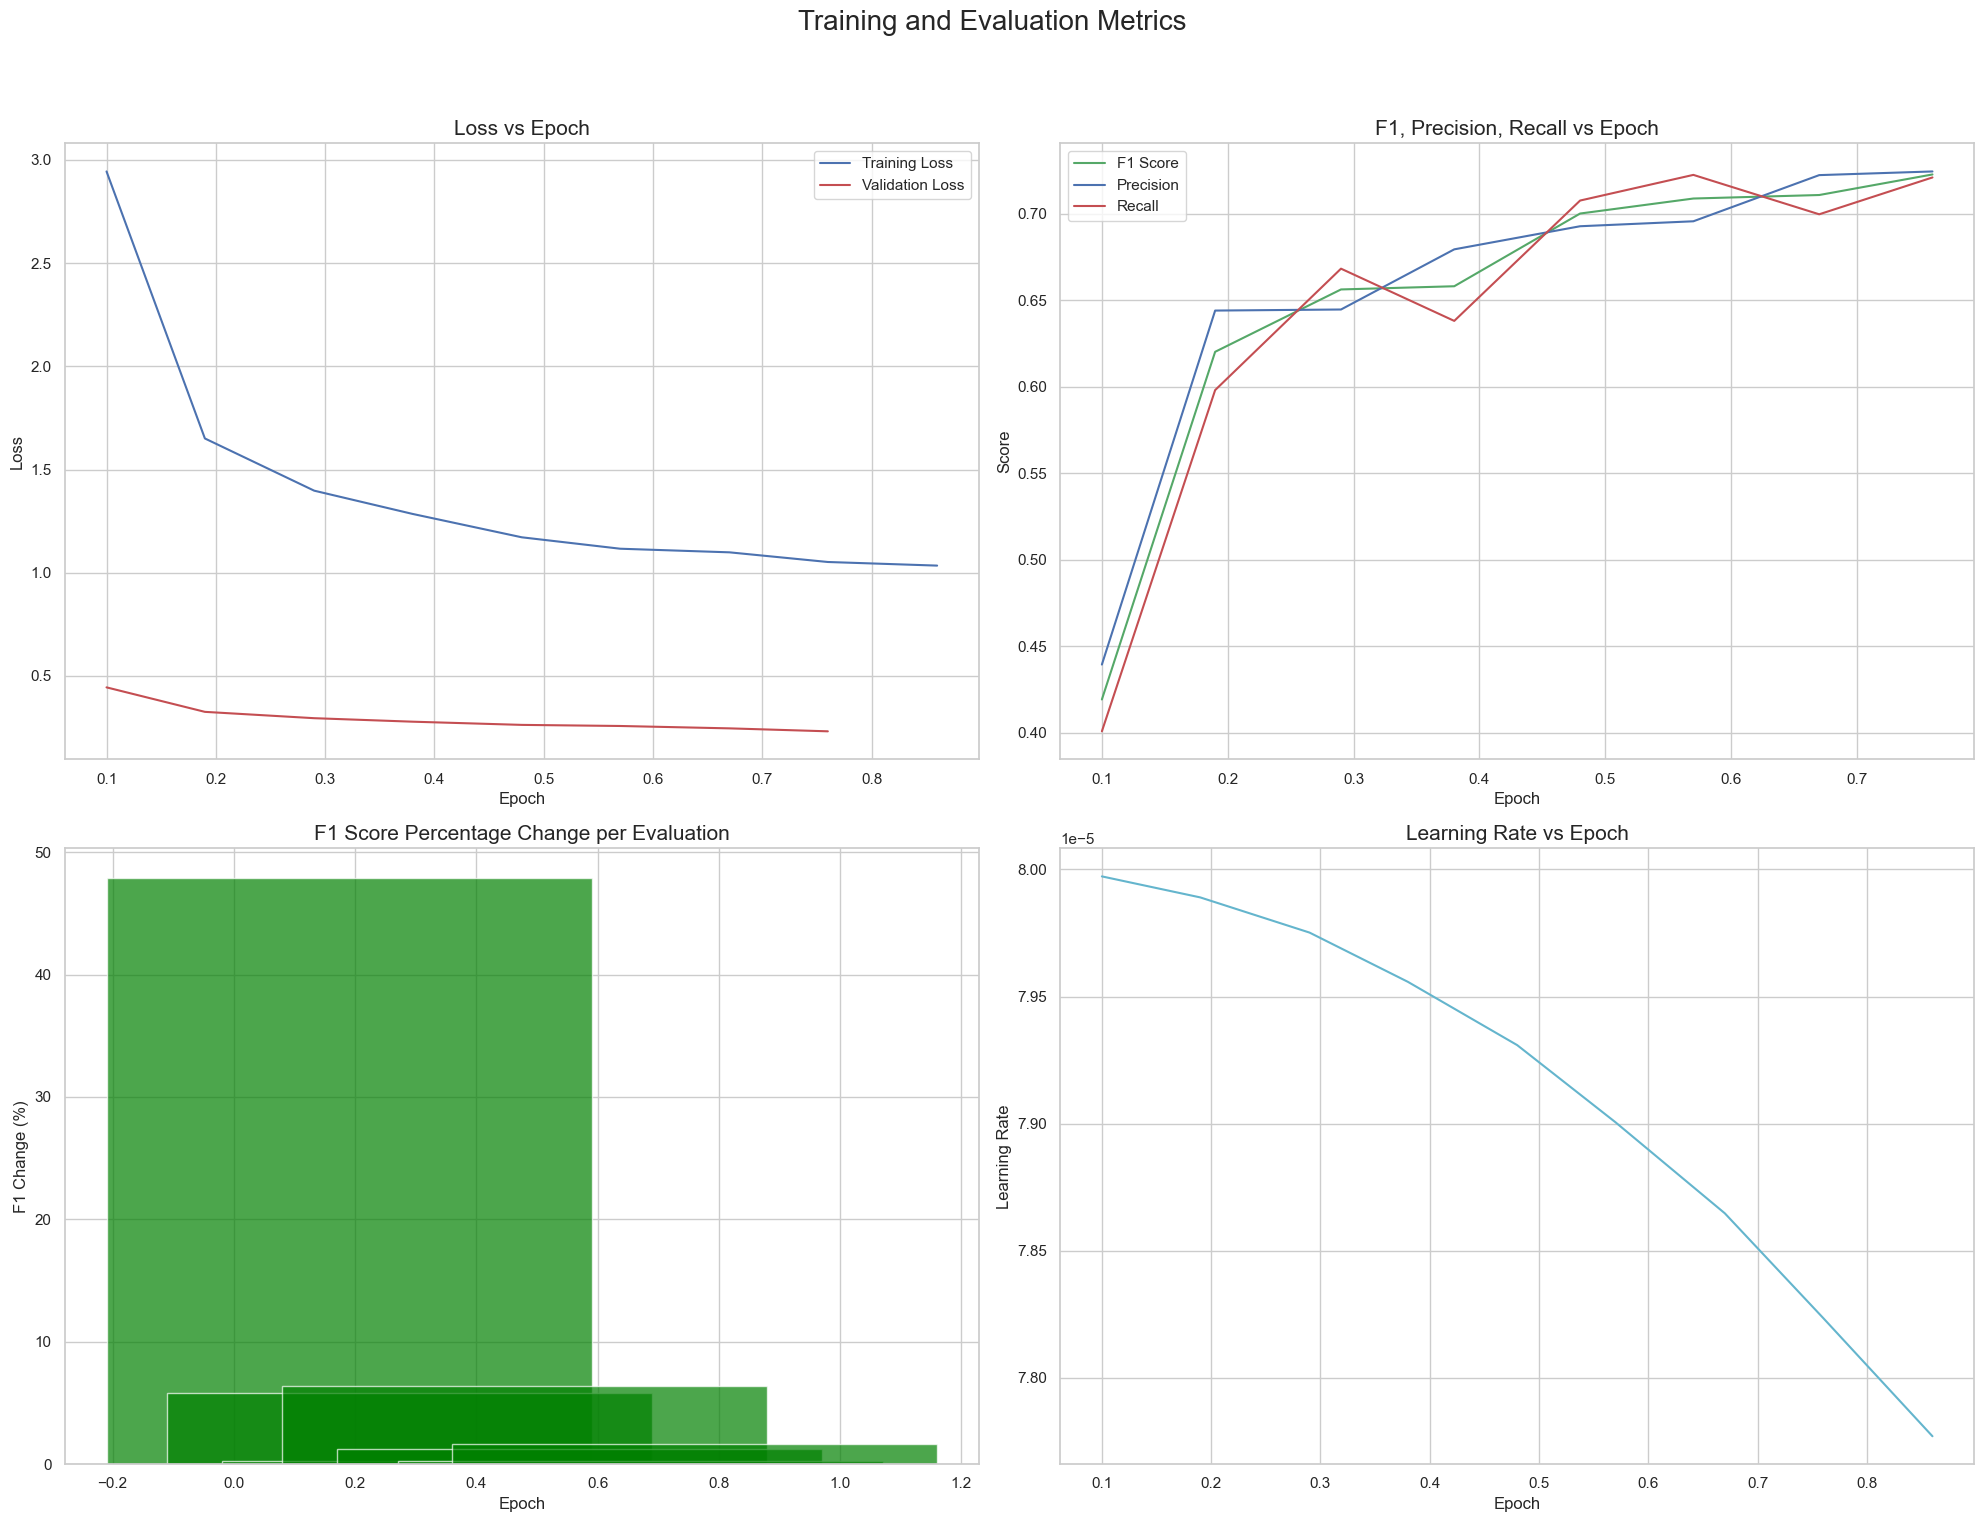


Best F1 Score: 0.7226 at epoch 0.76
Corresponding Precision: 0.7243, Recall: 0.7208

F1 Score Improvements:
Epoch 0.19: F1 change: 0.2008 (47.90%)
Epoch 0.29: F1 change: 0.0360 (5.81%)
Epoch 0.38: F1 change: 0.0018 (0.28%)
Epoch 0.48: F1 change: 0.0420 (6.38%)
Epoch 0.57: F1 change: 0.0087 (1.24%)
Epoch 0.67: F1 change: 0.0020 (0.29%)
Epoch 0.76: F1 change: 0.0119 (1.67%)


In [30]:
train_df, eval_df = visualize_training_log('train_xlm_base_biLSTM.log')